In [2]:
# Import modelflow

%load_ext autoreload
%autoreload 2

In [21]:
%matplotlib inline

from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import pandas as pd

import modeljupyter as mj
from modelvis import waterplot

from modelinvert import targets_instruments
from modelclass import model
model.widescreen()
model.modelflow_auto()



In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# Load model and data, and run 

if not 'masia' in locals():
    print('Load model')
    masia,baseline = model.modelload('Asia_sep7.pcim',run=1,silent=1)
from inject import inject
inject(masia)    

Load model


In [6]:
co2_input_var = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2')]
co2_input_var_asean = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2') and  var.split('_')[0] in masia.countries_ASEAN ]

In [7]:
co2_baseline = baseline.loc[:,co2_input_var].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))
co2_baseline_asean = baseline.loc[:,co2_input_var_asean].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))

In [8]:
# Variables to inputwidget

outvar = 'GDI GCARBR CO2 LNN'.split()
displayvar = 'WLD_CO2 ASP_CO2 G20_CO2 '

#  masia.countries_GCARBR_A is list of all countries in the model with a countries_GCARBR_A 
#  masia.countries_ASEAN is list of all countries in ASEAN 
countries_rest = [country for country in masia.countries_GCARBR_A if country not in masia.countries_ASEAN]

slidedef_allasean =  {'All ASEAN countries' : {'var': ' '.join([f'{country}_GCARBR_A' for country in masia.countries_ASEAN ])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_allrest =  {'Rest of the world' : {'var': 
    ' '.join([f'{country}_GCARBR_A' for country in countries_rest])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_countries = {masia.iso_dict.get(country,country)+', Extra' : 
                      {'var': f'{country}_GCARBR_A', 'value': 0.0,'min':-40,'max':40,'op':'+impulse','step':10,'dec':0} 
                      for country in  masia.countries_ASEAN}

slidedef = {**slidedef_allasean,**slidedef_allrest,**slidedef_countries}

# Simulations  with UNESCAP Carbon Pricing Instrument (CPI)  model


# Baseline 

# World $CO^2$

# ASEAN $CO^2$

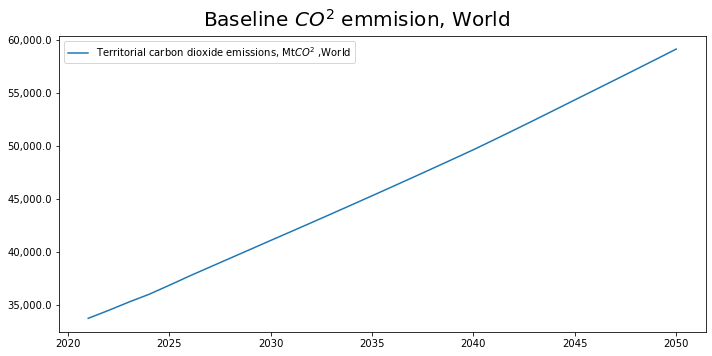

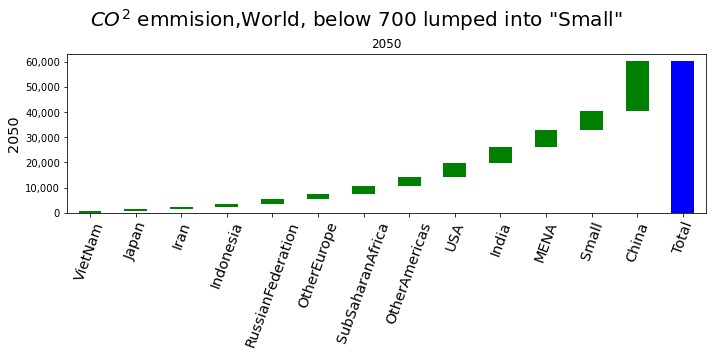

In [9]:
masia['wld_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision, World',top=0.9,ysize=5);

threshold =700
waterplot(co2_baseline.loc[[2050],:].T,autosum=1,threshold = 700,allsort=1,title = f'$CO^2$ emmision,World, below {threshold} lumped into "Small"',top=0.85);

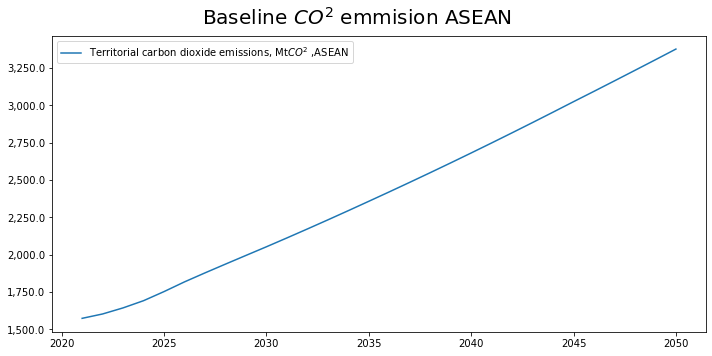

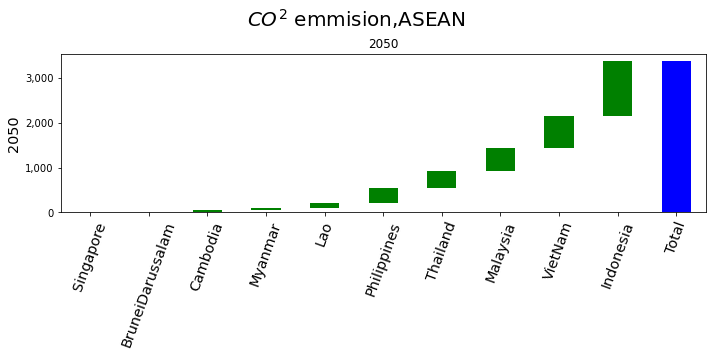

In [10]:
masia['asean_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision ASEAN',top=0.9,ysize=5);

threshold =0.1
waterplot(co2_baseline_asean.loc[[2050],:].T,autosum=1,threshold = 0 ,allsort=1,title = f'$CO^2$ emmision,ASEAN',top=0.85);

# Input Carbon tax rate, US\$ per tonne 

In [11]:
from modelwidget import sumslidewidget,slidewidget, updatewidget, tabwidget,sheetwidget
outvar = 'GDI GCARBR CO2 LNN'.split()
displayvar = 'WLD_CO2 ASP_CO2 G20_CO2'

#  masia.countries_GCARBR_A is list of all countries in the model with a countries_GCARBR_A 
#  masia.countries_ASEAN is list of all countries in ASEAN 
countries_rest = [country for country in masia.countries_GCARBR_A if country not in masia.countries_ASEAN]

slidedef_allasean =  {'All ASEAN countries' : {'var': ' '.join([f'{country}_GCARBR_A' for country in masia.countries_ASEAN ])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_allrest =  {'Rest of the world' : {'var': 
    ' '.join([f'{country}_GCARBR_A' for country in countries_rest])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_countries = {masia.iso_dict.get(country,country)+', Extra' : 
                      {'var': f'{country}_GCARBR_A', 'value': 0.0,'min':-40,'max':40,'op':'+impulse','step':10,'dec':5} 
                      for country in  masia.countries_ASEAN}

updatevar = [f'{country}_GCARBR_A' for country in masia.countries_ASEAN ]
smalldf = baseline.loc[2022:2040, updatevar]

tabsharedef = {masia.iso_dict.get(country,country) : sumslidewidget(
                {'Environmental protection':{'var': f'{country}_SHAREE_A', 'value': 0.25,'min':0.0,'max':1,'op':'=','step':0.05,'dec':2} ,
                 'Health'                  :{'var': f'{country}_SHAREH_A', 'value': 0.25,'min':0.0,'max':1,'op':'=','step':0.05,'dec':2} ,
                 'Social protection'       :{'var': f'{country}_SHARESP_A','value': 0.25,'min':0.0,'max':1,'op':'=','step':0.05,'dec':2} ,
                 'Energy efficiency gains' :{'var': f'{country}_SHAREX_A', 'value': 0.25,'min':0.0,'max':1,'op':'=','step':0.05,'dec':2} 
                } , expname='Share (the sum can max be 1.0) of Carbon revenue spent on:', maxsum=1.0)  
               
               for country in masia.countries_ASEAN }


tabdef = {'Areawide Carbon tax 2022'  : slidewidget( {**slidedef_allasean,**slidedef_allrest}),
          'Single country add on 2022': slidewidget(slidedef_countries),
          'Individual tax rates'      : (sheet1 :=  sheetwidget(df_var = smalldf,transpose=0,trans=masia.get_a_country)),
          'Use of carbon tax revenue' : tabwidget(tabdefdict = tabsharedef,tab=True,selected_index = 0)}


wtab = tabwidget(tabdefdict = tabdef,tab=False)
xx = updatewidget(masia,wtab,lwreset=True,varpat = displayvar,outputwidget='keep_viz') # output widget = either keep_viz or jupviz 
xx.wtotal

Solving Asia_7sept:   0%|          | 0/30

# Additional information
Press \<enter> in the cell's below to compare the $CO^2$ emissions in each county in the Business as usual"

# World reduction 

# ASEAN reduction

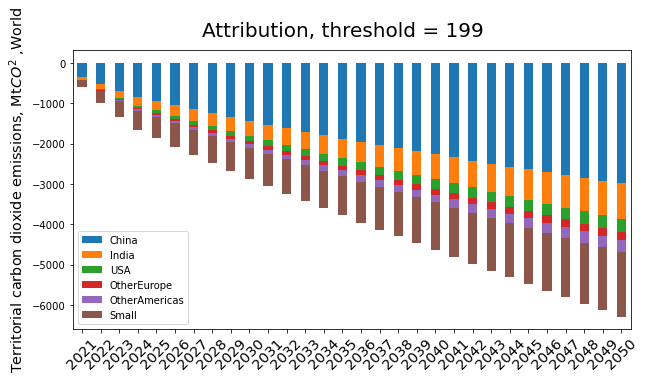

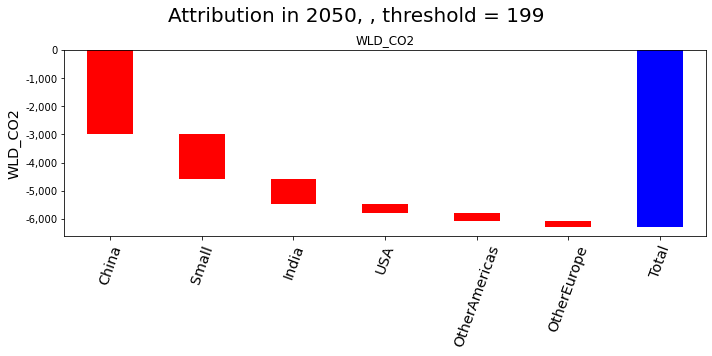

In [22]:
if hasattr(masia,'inputwidget_alternativerun'):
    Threshold =199
    masia.dekomp_plot('WLD_CO2',pct=0,threshold=Threshold,nametrans=masia.country_get)
    masia.dekomp_plot_per('WLD_CO2',pct=0,threshold=Threshold,per=2050,sort=True,nametrans=masia.country_get);
else:
    display(Markdown('# Try make an alternative and run again'))

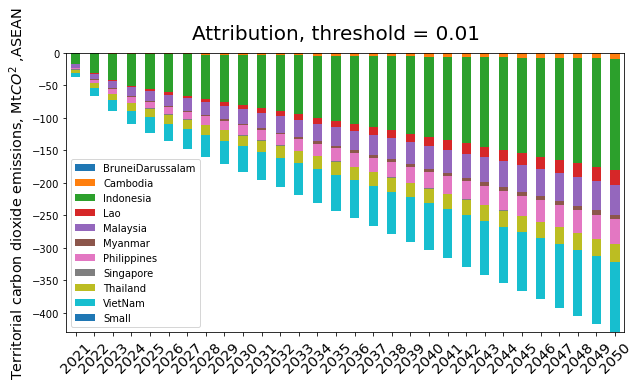

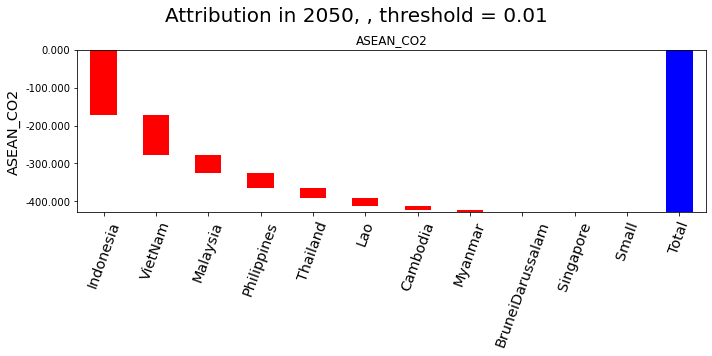

In [23]:
if hasattr(masia,'inputwidget_alternativerun'):
    Threshold =0.01
    masia.dekomp_plot('ASEAN_CO2',pct=0,threshold=Threshold,nametrans=masia.country_get)
    masia.dekomp_plot_per('ASEAN_CO2',pct=0,threshold=Threshold,per=2050,sort=True,nametrans=masia.country_get);
else:
    display(Markdown('# Try make an alternative and run again'))